# Подключение библиотек и Google диска


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


# Глобальные параметры

In [ ]:
path = '/content/drive/My Drive/Базы/Самолеты/' # Путь к директории на диске, где находятся изображения
name_classes = ['Самолеты'] # Названия классов
num_classes = len(name_classes) # Количество классов
input_shape = (416, 416) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

# Создание модели

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:       
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров   
          use_weights - использовать ли предобученные веса         
          weights_path - путь к сохраненным весам модели  
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False, 
        weights_path = 'yolo.h5'        
        ):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра, описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------
    
    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок, использующий информацию из предыдущих слоев
    # С помощью слоя Add (суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объединить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, используя UpSampling
    x = Concatenate()([x,base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объединить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, используя UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока.
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков 
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки.
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров                    
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров) 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровня сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычисления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычисления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask # Увеличиваем счетчик на единицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонент - для значений, которые были верно спредиктены
        # 2 компонент - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x, y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соответствующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x, y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соответствующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем минимальные координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    

In [ ]:
# Создаем набор цветов для ограничивающих рамок
import colorsys 
hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
np.random.seed(43)
np.random.shuffle(colors)
np.random.seed(None)

In [ ]:
# Функция расчета сигмоиды для вектора
def sigmoid(x): # На вход подаем массив данных
  return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

In [ ]:
def non_max_suppression_fast(boxes, scores, overlapThresh):	
  if len(boxes) == 0: # Если нет ни одного бокса
    return []

  pick = [] # Индексы возвращаемых боксов
  
  x1 = boxes[:,0] # координаты x левых верхних углов
  y1 = boxes[:,1] 
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(scores)
  
  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    
    overlap = (w * h) / area[idxs[:last]]
    idxs = np.delete(idxs, np.concatenate(([last],
                                           np.where(overlap > overlapThresh)[0])))
  
  return boxes[pick].astype("int"), scores[pick]

In [ ]:
# Решейпим предикт
feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
print(feats.shape)
print (feats[0][6][7][1])

(1, 13, 13, 3, 6)
[-0.3638747 -1.0982834  0.7444668 -0.556719  -2.8235753 11.4344425]


In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/Базы/Самолеты/weights/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<tf.Tensor 'input_1:0' shape=(None, 416, 416, 3) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 13, 13, 3, 6) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(None, 26, 26, 3, 6) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(None, 52, 52, 3, 6) dtype=float32>]

In [ ]:
# Выводим выходную размерность модели
model_YOLO.output

<tf.Tensor 'yolo_loss/Identity:0' shape=() dtype=float32>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

# Обнаружение объектов


In [ ]:
model_weight = '/content/drive/MyDrive/УИИ/Object Detection/База (веса модели YOLOv3 самолеты-500 эпох)/YOLOv3__el1000__opt0.00001__ep0_100.h5'
max_boxes = 5 # Максимальное количество ограничивающих рамок на изображении

In [ ]:
model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3) # Создаем модель

In [ ]:
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(model_weight))

/content/drive/MyDrive/УИИ/Object Detection/База (веса модели YOLOv3 самолеты-500 эпох)/YOLOv3__el1000__opt0.00001__ep0_100.h5 загружены.


## 1 - Вариант

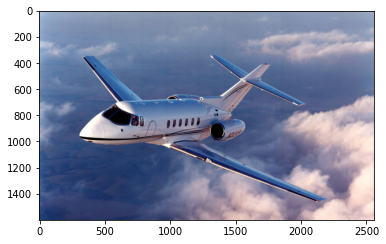

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open('/content/drive/MyDrive/УИИ/Object Detection/Примеры самолетов/2.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение
plt.show()

(1, 416, 416, 3)


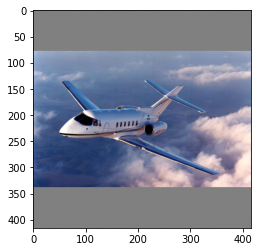

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

[416 416]
[1600 2560]


In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

(13, 13, 1, 2)


In [ ]:
# Решейпим предикт
feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
print(feats.shape)
print (feats[0][6][7][1])

(1, 13, 13, 3, 6)
[-1.123829    0.7050264   0.6841475  -0.26595807 -0.827107   11.454967  ]


In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

In [ ]:
# Корректируем ограничивающие рамки (размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэффициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)

_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные



In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

(array([254, 257]), array([0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0

In [ ]:
font = ImageFont.truetype(font='/content/drive/MyDrive/УИИ/Object Detection/font.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
thickness = (image.size[0] + image.size[1]) // 300

0
Самолеты 0.75 (217, 232) (2560, 1422)
0
Самолеты 0.93 (169, 273) (2469, 1396)


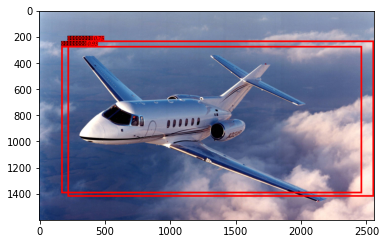

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

### Non-maximum Suppression

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0
print(new_boxes)

[[ 272  169 1396 2468]]


Самолеты 0.93 (169, 272) (2468, 1396)


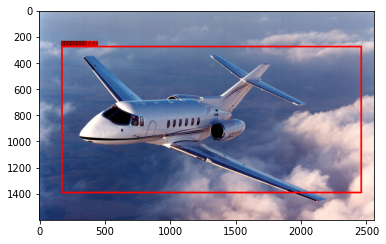

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

In [ ]:
files.download('new_image.jpg')

## 2 - Вариант

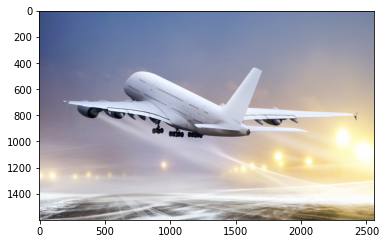

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open('/content/drive/MyDrive/УИИ/Object Detection/Примеры самолетов/3.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение
plt.show()

(1, 416, 416, 3)


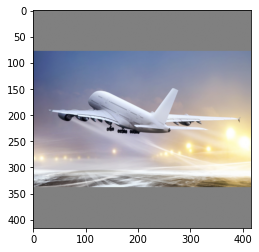

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

[416 416]
[1600 2560]


In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

(13, 13, 1, 2)


In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

In [ ]:
# Корректируем ограничивающие рамки (размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэффициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)

_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные



In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

(array([249, 252, 255]), array([0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0

0
Самолеты 0.84 (526, 476) (2391, 1015)
0
Самолеты 0.97 (361, 462) (2214, 1017)
0
Самолеты 0.88 (291, 466) (1929, 989)


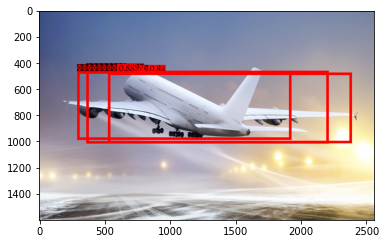

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

### Non-maximum Suppression

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0
print(new_boxes)

[[ 462  361 1016 2214]]


Самолеты 0.97 (361, 462) (2214, 1016)


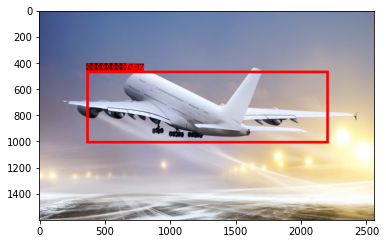

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

In [ ]:
files.download('new_image.jpg')

## 3 - Вариант

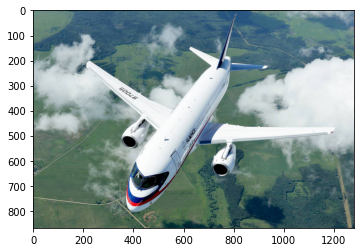

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open('/content/drive/MyDrive/УИИ/Object Detection/Примеры самолетов/4.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение
plt.show()

(1, 416, 416, 3)


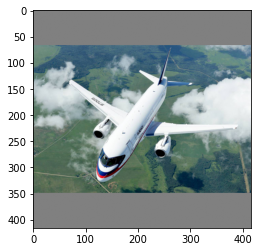

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

[416 416]
[ 868 1280]


In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

(13, 13, 1, 2)


In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

In [ ]:
# Корректируем ограничивающие рамки (размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэффициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)

_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные



In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

(array([249, 252, 255]), array([0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0

0
Самолеты 0.84 (263, 272) (1196, 541)
0
Самолеты 0.97 (181, 265) (1107, 542)
0
Самолеты 0.88 (146, 267) (965, 528)


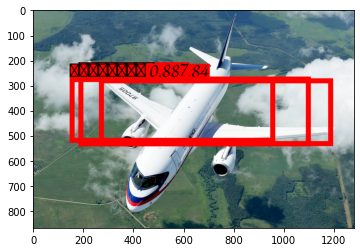

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

### Non-maximum Suppression

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0
print(new_boxes)

[[ 265  180  542 1107]]


Самолеты 0.97 (180, 265) (1107, 542)


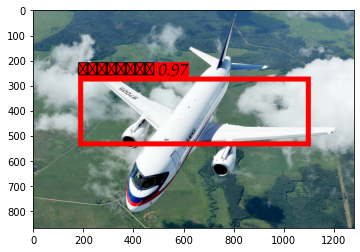

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

In [ ]:
files.download('new_image.jpg')

## 4 - Вариант

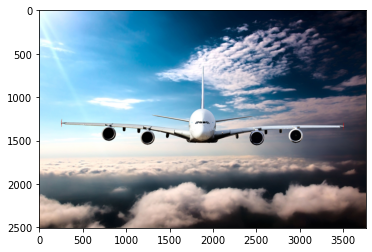

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open('/content/drive/MyDrive/УИИ/Object Detection/Примеры самолетов/1.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение
plt.show()

(1, 416, 416, 3)


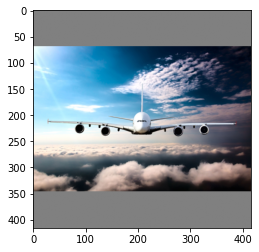

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

[416 416]
[2507 3760]


In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

(13, 13, 1, 2)


In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

In [ ]:
# Корректируем ограничивающие рамки (размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэффициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)

_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные



In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

(array([249, 252, 255]), array([0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0

0
Самолеты 0.84 (772, 778) (3512, 1569)
0
Самолеты 0.97 (531, 757) (3252, 1572)
0
Самолеты 0.88 (427, 762) (2834, 1531)


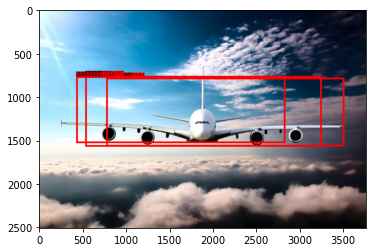

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

### Non-maximum Suppression

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0
print(new_boxes)

[[ 756  530 1572 3252]]


Самолеты 0.97 (530, 756) (3252, 1572)


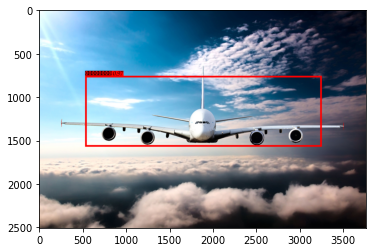

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

In [ ]:
files.download('new_image.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5 - Вариант

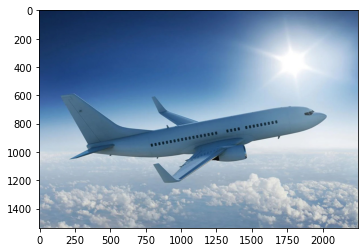

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open('/content/drive/MyDrive/УИИ/Object Detection/Примеры самолетов/5.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение
plt.show()

(1, 416, 416, 3)


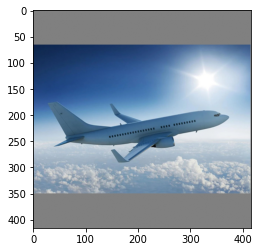

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image 
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

[416 416]
[1536 2248]


In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

(1, 1, 1, 3, 2)
[[[[[116  90]
    [156 198]
    [373 326]]]]]


In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

(13, 13, 1, 2)


In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

In [ ]:
# Корректируем ограничивающие рамки (размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим, на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэффициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)

_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные



In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

(array([249, 252, 255]), array([0, 0, 0]))


In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
classes_out = np.ones_like(_scores_out,'int32') * 0

0
Самолеты 0.84 (462, 484) (2100, 957)
0
Самолеты 0.97 (317, 471) (1944, 958)
0
Самолеты 0.88 (256, 474) (1694, 934)


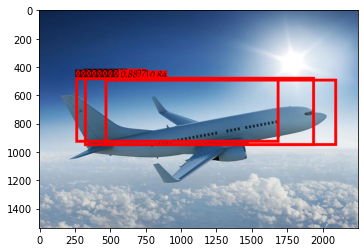

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

### Non-maximum Suppression

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0

Самолеты 0.97 (317, 471) (1944, 958)


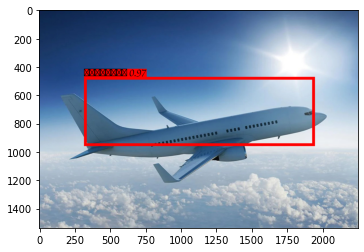

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])
  
  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)
plt.show()

In [ ]:
files.download('new_image.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Выводы:

1. В данном задании было подано 5 разных изображений самолета с разных ракурсов.
2. Как видно не все изображения были удачно распознаны. 
3. Для более лучшего результата нужна еще большая обучающая база для обучения.
4. В уроке нет файла **font.otf**, данный файл был скачен с интернета. Поэтому рамки не подписаны должным образом.
5. Данный урок дает понимаение каким образом работает нейронная сеть по обнаружению различных объектов. 